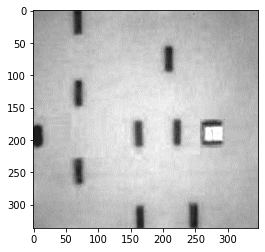

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
from collections import namedtuple

from matplotlib import pyplot as plt
%matplotlib inline

plt.gray()

def showImg(img):
  plt.imshow(img)
  plt.show()

# read image
img = cv.imread('./Cenario.jpg', cv.IMREAD_COLOR)
# transform to gray
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(img)
plt.show()

Treshold

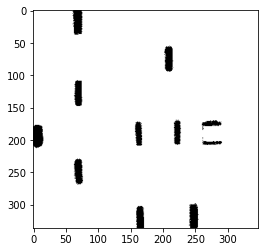

In [2]:
# transform image to binary
(T, treshold) = cv.threshold(img, 100, 255, cv.THRESH_BINARY)
showImg(treshold)

ENCONTRANDO O ROBÔ

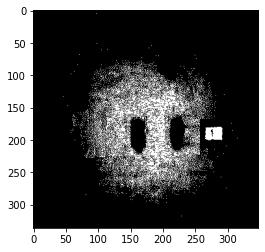

In [3]:
# transform image to binary
(T, treshold_robot) = cv.threshold(img, 220, 255, cv.THRESH_BINARY)
showImg(treshold_robot)

Abertura

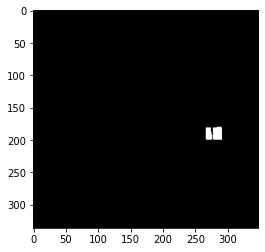

In [4]:
kernel = np.ones((7,7),np.uint8)
opening_robot = cv.morphologyEx(treshold_robot, cv.MORPH_OPEN, kernel)
showImg(opening_robot)

Fechamento

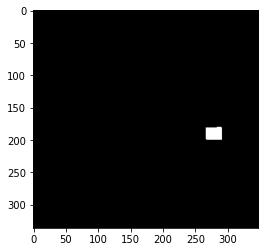

In [5]:
kernel = np.ones((5,5),np.uint8)
closing_robot = cv.morphologyEx(opening_robot, cv.MORPH_CLOSE, kernel)
showImg(closing_robot)

Encontrando o contorno

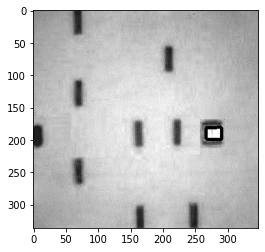

In [6]:
contours = cv.findContours(closing_robot, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
robot = contours[0]
cv.drawContours(img, robot, -1, (0,255,0), 3)
showImg(img)

In [7]:
Point = namedtuple('Point', ['x', 'y'])

img = cv.imread('./image_trabalho1.jpg', cv.IMREAD_COLOR)
height, width, channels = img.shape
GRID_SIZE = 50

gridH = []
gridV = []

#Draw vertical
for x in range(0, width -1, GRID_SIZE):
  if x != 0:
    point = Point(x=(x, 0), y=(x, height))
    cv.line(img, point.x, point.y, (255, 0, 0), 1, 1)
    gridV.append(point)

#Draw horizontal
for x in range(0, height -1, GRID_SIZE):
  if x != 0:
    point = Point(x=(0, x), y=(width,x))
    cv.line(img, point.x, point.y, (255, 0, 0), 1, 1)
    gridH.append(point)

cv2_imshow(img)

AttributeError: ignored

In [0]:
 print(gridH)
 print(gridV)